The case study is from an open source dataset from Kaggle. 

Link to the Kaggle project site:

https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

### Given a Bank customer, can we build a classifier which can determine whether they will leave or not using Neural networks?

The points distribution for this case is as follows:

### 1. Read the dataset

In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [326]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from numpy.random import seed
seed(100)

In [327]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense #Creating a Dense DNN

import tensorflow as tf
tf.random.set_seed(100)
tf.keras.backend.clear_session()

In [328]:
data = pd.read_csv('bank.csv')

In [329]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [330]:
data.shape

(10000, 14)

In [331]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#### *There are 14 features and 10000 datapoints. There doesn't seem to be any NULL value for any of the features*
#### *While most of the features seem to be CONTINUOUS data, the fact is features like NumOfProducts, HasCrCard, IsActiveMember is actually CATEGORICAL in nature although they are shown to be of numerical & continuous type* 
#### *Some features like SURNAME, GEOGRAPHY, GENDER are outright CATEGORICAL in nature & shown to be of OBJECT type*

In [332]:
print ("Unique values for Surname: ",data['Surname'].nunique())
print ("Unique values for Geography: ",data['Geography'].nunique())
print ("Unique values for Gender: ",data['Gender'].nunique())

Unique values for Surname:  2932
Unique values for Geography:  3
Unique values for Gender:  2


In [333]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [334]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

#### *There are 3 distinct values for GEOGRAPHY & 2 distinct values for GENDER. We can substitute the same with dummy encoded values. For SURNAME, it will be better to drop the same as there doesn't seem to be much correlation between someones SURNAME & whether he/she continues business with the Bank*

#### *The data is skewed towards customer's who have left the bank, with the number being 4x the number of customers continuing with the Bank*

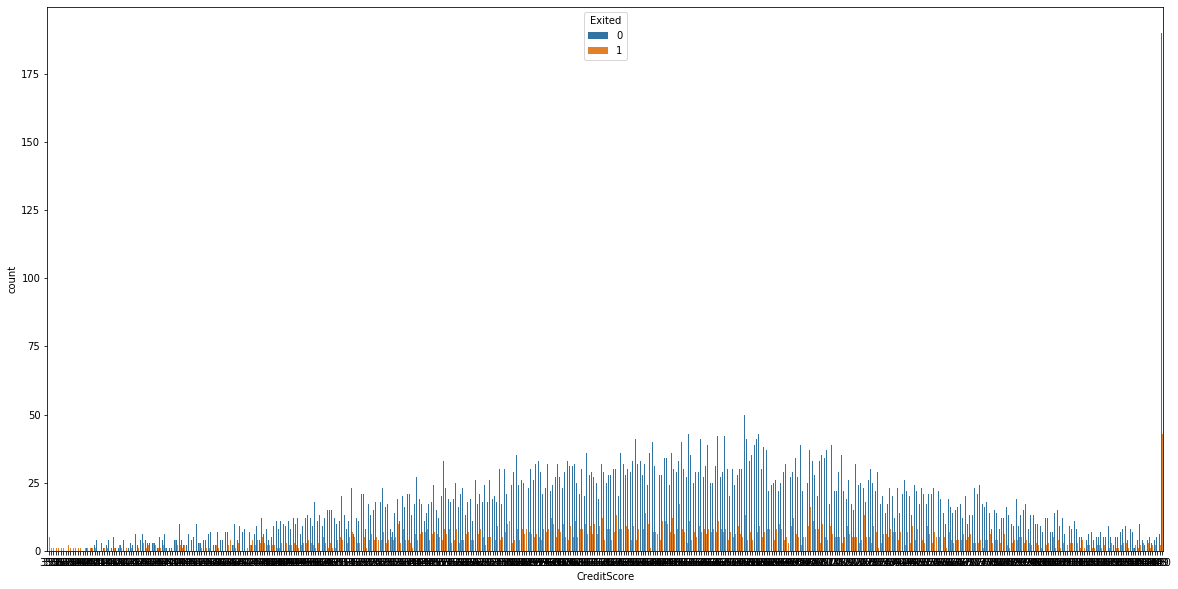

In [335]:
plt.figure(figsize=(20,10))
sns.countplot(x=data['CreditScore'],hue=data['Exited'])

#### *There doesn't seem to be much correlation between CreditScore & whether a customer stays with the Bank or not*

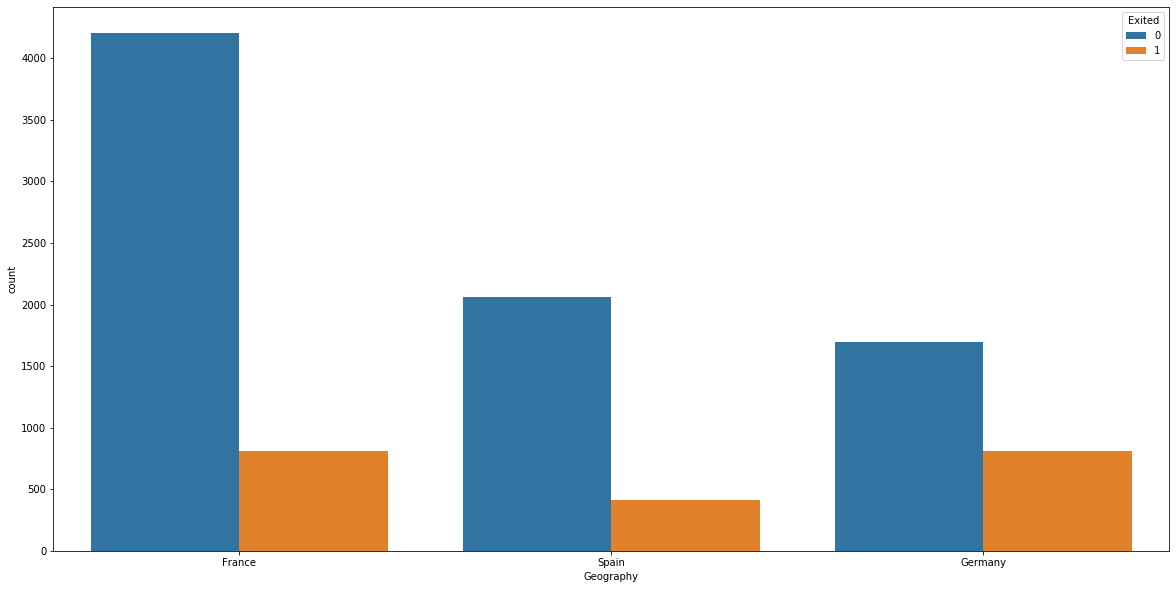

In [336]:
plt.figure(figsize=(20,10))
sns.countplot(x=data['Geography'],hue=data['Exited'])

#### *As we have seen earlier, majority of the Bank's customers are from FRANCE, while SPAIN & GERMANY have comparable number of customers. However, even in the same GERMANS seem to be more loyal to the Bank than the SPANISH or FRENCH. Thus, we can try building seperate predictive models for the 3 different geographies*

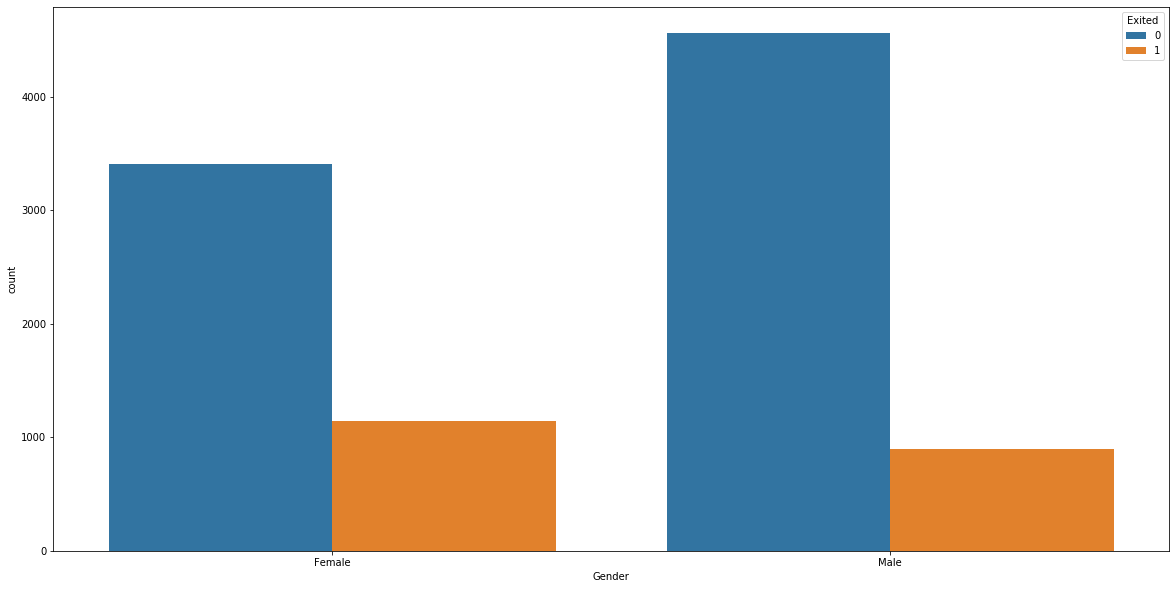

In [337]:
plt.figure(figsize=(20,10))
sns.countplot(x=data['Gender'],hue=data['Exited'])

#### *From the above, we can see that although the proportion of men is higher than women as the Bank's customers, the retention rate is quiet comparable. However, the retention rate amongst FEMALES is higher than that is in MALES*

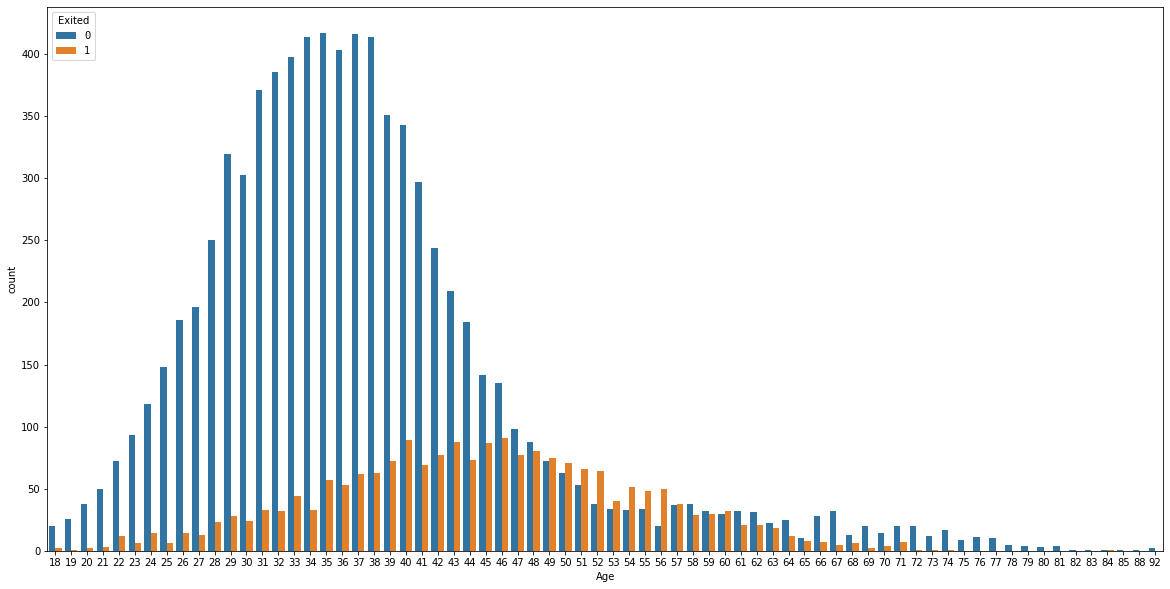

In [338]:
plt.figure(figsize=(20,10))
sns.countplot(x=data['Age'],hue=data['Exited'])

#### *There doesn't seem to be much correlation between a customers AGE and whether he/she stays invested with the Bank*

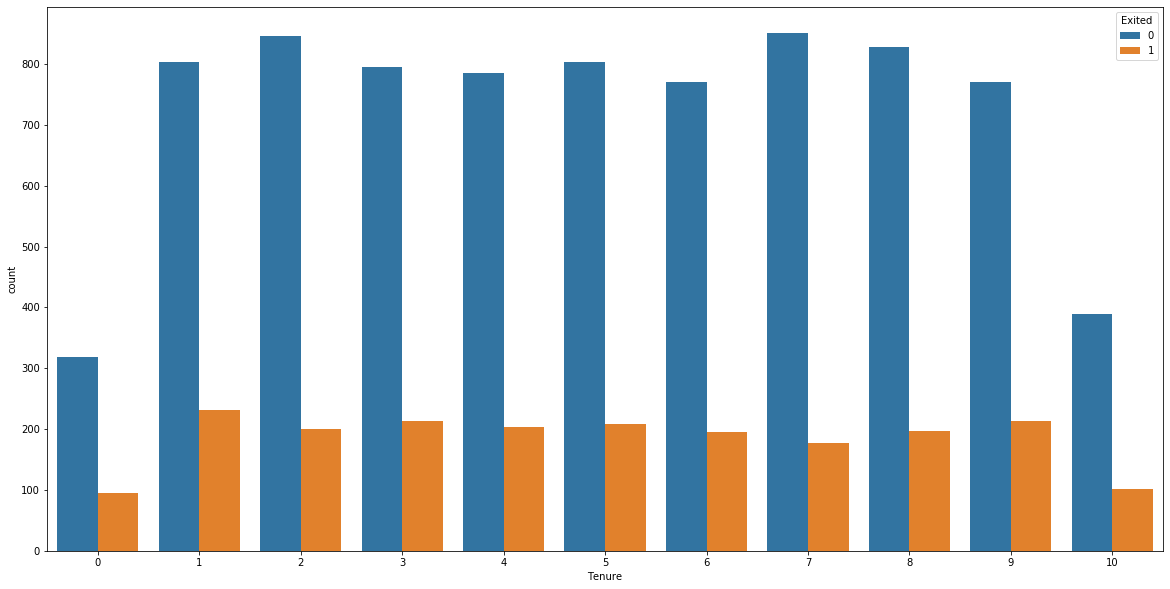

In [339]:
plt.figure(figsize=(20,10))
sns.countplot(x=data['Tenure'],hue=data['Exited'])

#### *Again there doesn't seem to be much correlation between the TENURE  a customer has stayed invested in the Bank & whether he/she has still quit*

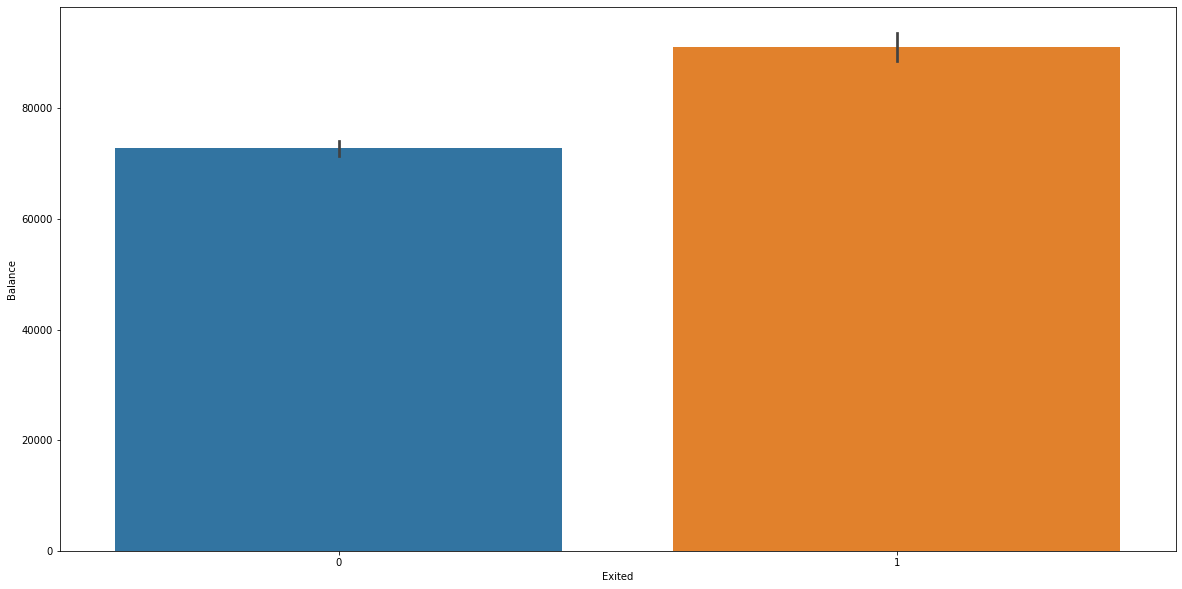

In [340]:
plt.figure(figsize=(20,10))
sns.barplot(x=data['Exited'],y=data['Balance'])

#### *The distribution of account balance doesn't seem to have much impact on whether a person will continue to remain invested with the Bank, but there seems to be a slightly more number of people continuing with the Bank, if they have a large Bank balance*

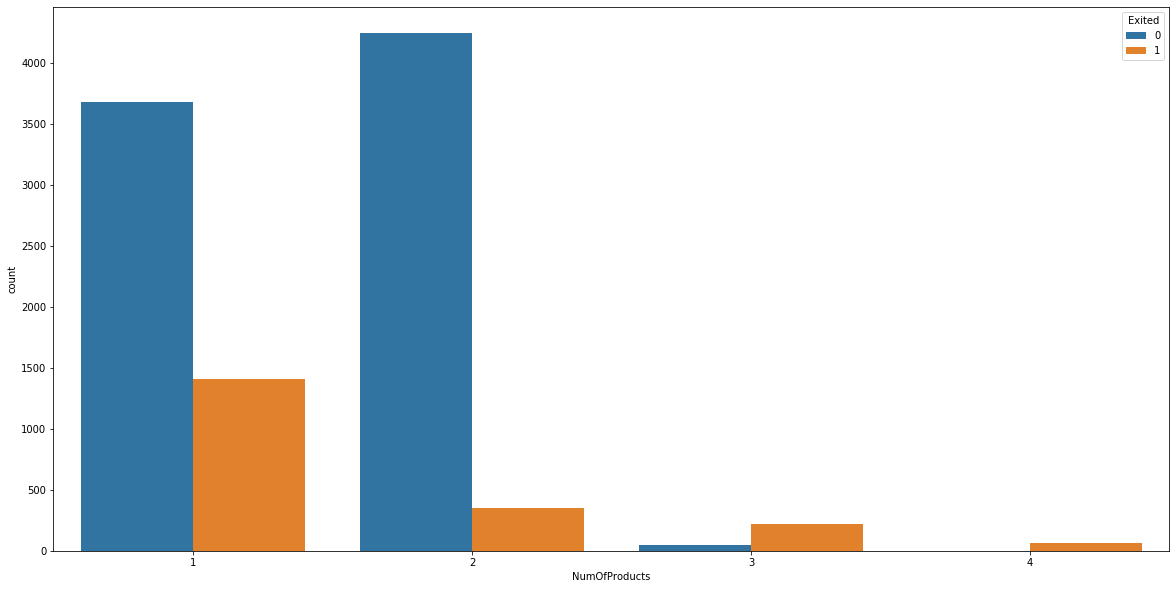

In [341]:
plt.figure(figsize=(20,10))
sns.countplot(x=data['NumOfProducts'],hue=data['Exited'])

#### *Thus as the number of products taken by a customer increases, the better is his/her retention. Maximum number of people who have quit the services of the Bank seem to have either 1-2 products*

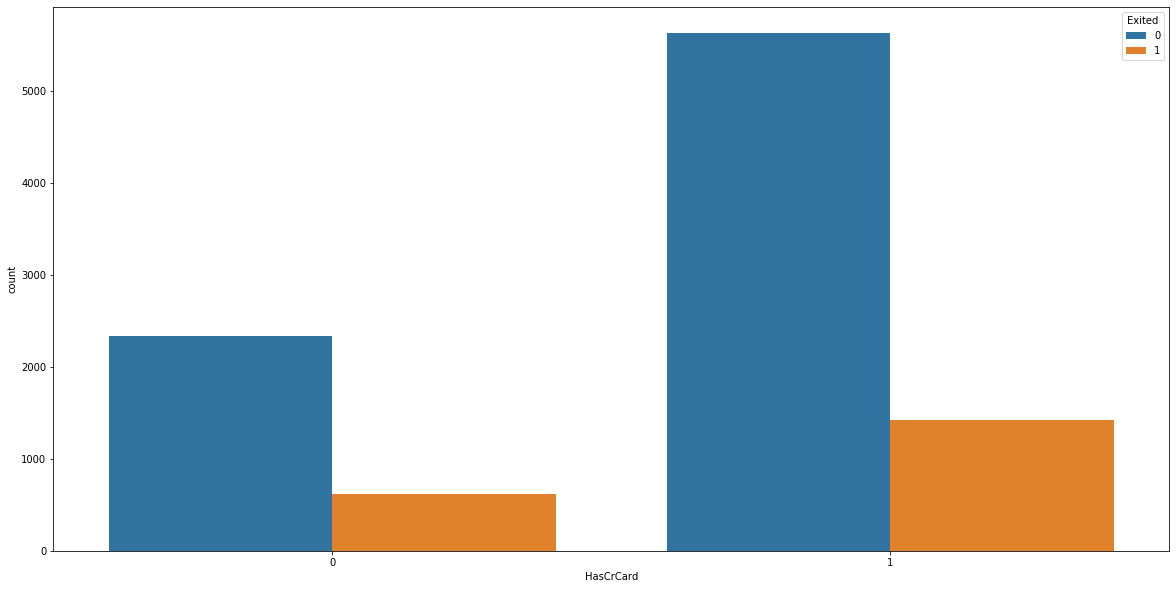

In [342]:
plt.figure(figsize=(20,10))
sns.countplot(x=data['HasCrCard'],hue=data['Exited'])

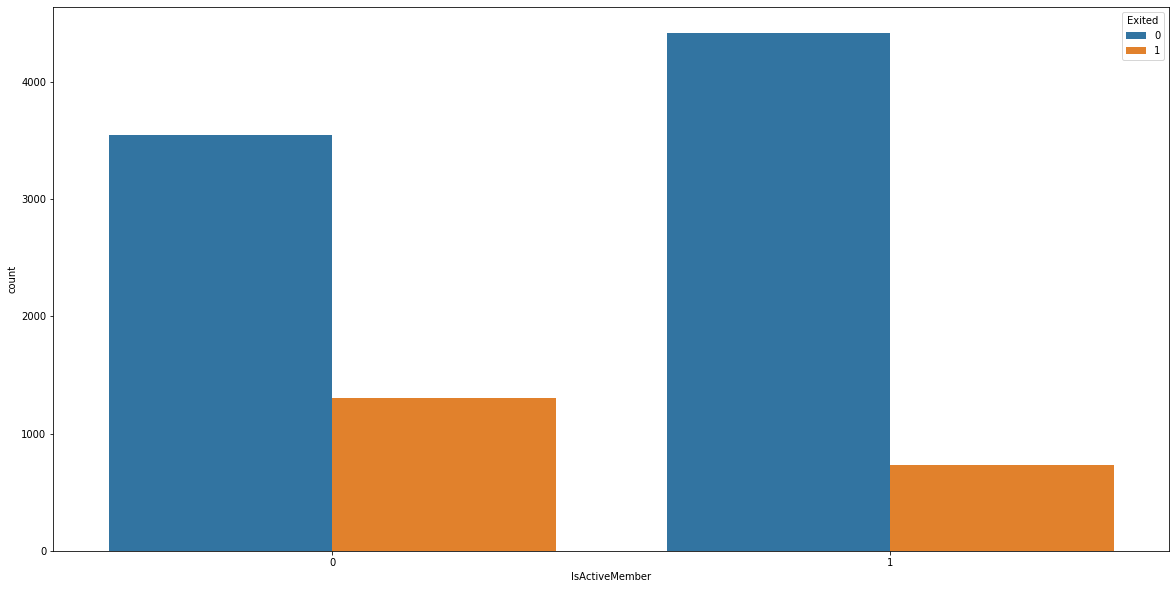

In [343]:
plt.figure(figsize=(20,10))
sns.countplot(x=data['IsActiveMember'],hue=data['Exited'])

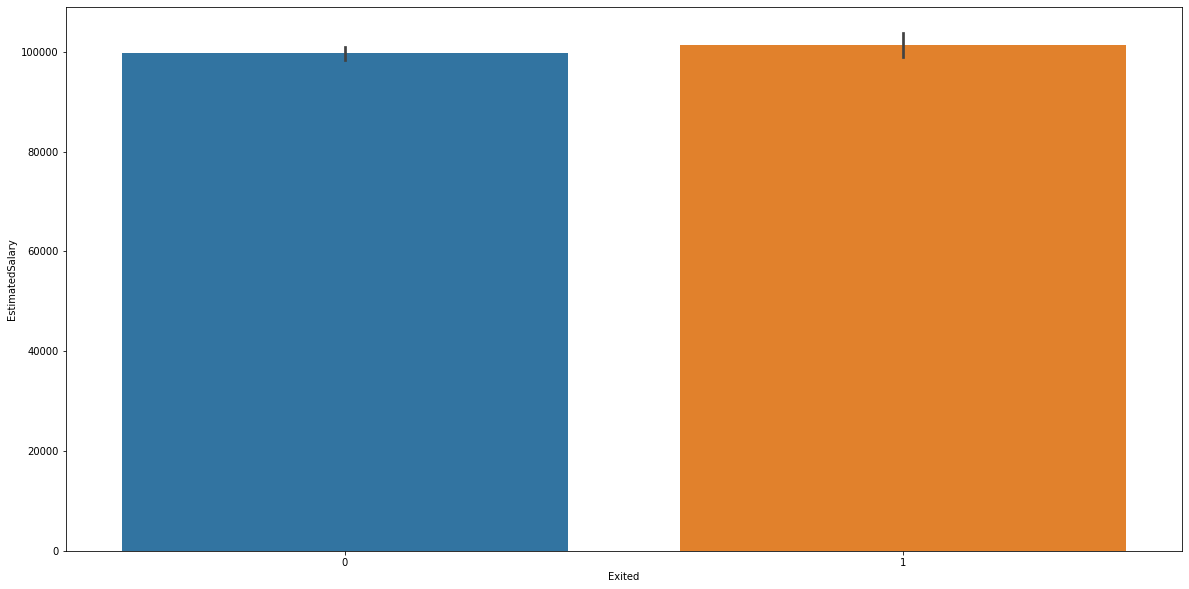

In [344]:
plt.figure(figsize=(20,10))
sns.barplot(x=data['Exited'],y=data['EstimatedSalary'])

### 2. Drop the columns which are unique for all users like IDs (2.5 points)

In [345]:
data_bkup = data.copy()
data.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)

In [346]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [347]:
dum_df = pd.get_dummies(data=data, columns=['Geography','Gender'])
dum_df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,0,1,0,0,1


### 3. Distinguish the feature and target set (2.5 points)

In [348]:
dum_df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [349]:
y = np.ravel(dum_df['Exited'])
X = dum_df.drop('Exited',axis=1)

### 4. Divide the data set into Train and test sets

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=100,stratify=y)

### 5. Normalize the train and test data (2.5 points)

In [351]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
1485,475,46,10,0.00,2,0,0,122953.00,1,0,0,1,0
8462,817,59,1,118962.58,1,1,1,120819.58,1,0,0,0,1
1025,582,32,4,0.00,2,1,0,59668.81,1,0,0,1,0
1880,589,36,9,140355.56,2,1,0,136329.96,0,1,0,1,0
6245,591,39,8,0.00,2,0,0,42392.24,0,0,1,0,1


In [352]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [353]:
X_train[0:5]

array([[-1.82560073e+00,  6.66992761e-01,  1.72252211e+00,
        -1.22873174e+00,  8.06375500e-01, -1.54219920e+00,
        -1.03548640e+00,  3.99998596e-01,  9.94017892e-01,
        -5.81749192e-01, -5.68332053e-01,  1.09728311e+00,
        -1.09728311e+00],
       [ 1.71543517e+00,  1.90599703e+00, -1.39172035e+00,
         6.75835915e-01, -9.00497346e-01,  6.48424664e-01,
         9.65729726e-01,  3.62797114e-01,  9.94017892e-01,
        -5.81749192e-01, -5.68332053e-01, -9.11341831e-01,
         9.11341831e-01],
       [-7.17732774e-01, -6.67319531e-01, -3.53639533e-01,
        -1.22873174e+00,  8.06375500e-01,  6.48424664e-01,
        -1.03548640e+00, -7.03518599e-01,  9.94017892e-01,
        -5.81749192e-01, -5.68332053e-01,  1.09728311e+00,
        -1.09728311e+00],
       [-6.45255431e-01, -2.86087448e-01,  1.37649517e+00,
         1.01833334e+00,  8.06375500e-01,  6.48424664e-01,
        -1.03548640e+00,  6.33259153e-01, -1.00601811e+00,
         1.71895383e+00, -5.68332053e

### 6. Initialize & build the model (10 points)

In [354]:
model1 = Sequential()

# Define model architecture
model1.add(Dense(13, activation='tanh', input_shape=(13,)))
model1.add(Dense(50, activation ='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',metrics=['accuracy'])

model1.fit(X_train, y_train, verbose=1)

Train on 7000 samples
7000/7000 [==============================] - 1s 153us/sample - loss: 0.4611 - accuracy: 0.7996


In [355]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                182       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                700       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 933
Trainable params: 933
Non-trainable params: 0
_________________________________________________________________


In [356]:
y_pred = np.round(model1.predict(X_test))

loss, acc = model1.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %.3f' % acc)

loss, acc = model1.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Train Accuracy: 0.810
Test Accuracy: 0.805


In [357]:
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=[0 ,1]),index=['true:Not Exited', 'true:Exited'], columns=['pred:Not Exited', 'pred:Exited']))

                 pred:Not Exited  pred:Exited
true:Not Exited             2369           20
true:Exited                  565           46


In [358]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      2389
           1       0.70      0.08      0.14       611

    accuracy                           0.81      3000
   macro avg       0.75      0.53      0.51      3000
weighted avg       0.78      0.81      0.74      3000



### 7. Optimize the model (5 points)

In [366]:
model2 = Sequential()

# Define model architecture
model2.add(Dense(100, activation='tanh', input_shape=(13,)))
model2.add(Dense(100, activation ='tanh'))
model2.add(Dense(100, activation ='elu'))
model2.add(Dense(100, activation ='relu'))
model2.add(Dense(50, activation ='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
               optimizer='nadam',
               metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=10, batch_size=700, verbose=1)

Train on 7000 samples
Epoch 1/10
7000/7000 [==============================] - 2s 318us/sample - loss: 0.5037 - accuracy: 0.7950
Epoch 2/10
7000/7000 [==============================] - 0s 22us/sample - loss: 0.4180 - accuracy: 0.8187
Epoch 3/10
7000/7000 [==============================] - 0s 19us/sample - loss: 0.3862 - accuracy: 0.8433
Epoch 4/10
7000/7000 [==============================] - 0s 17us/sample - loss: 0.3580 - accuracy: 0.8570
Epoch 5/10
7000/7000 [==============================] - 0s 18us/sample - loss: 0.3445 - accuracy: 0.8643
Epoch 6/10
7000/7000 [==============================] - 0s 20us/sample - loss: 0.3388 - accuracy: 0.8630
Epoch 7/10
7000/7000 [==============================] - 0s 17us/sample - loss: 0.3375 - accuracy: 0.8637
Epoch 8/10
7000/7000 [==============================] - 0s 17us/sample - loss: 0.3323 - accuracy: 0.8633
Epoch 9/10
7000/7000 [==============================] - 0s 20us/sample - loss: 0.3306 - accuracy: 0.8646
Epoch 10/10
7000/7000 [=========

### 8. Predict the results using 0.5 as a threshold (5 points)

In [367]:
y_pred = np.round(model2.predict(X_test))

In [368]:
y_pred[0:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

### 9. Print the Accuracy score and confusion matrix (2.5 points)

In [369]:
loss, acc = model2.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %.3f' % acc)

loss, acc = model2.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Train Accuracy: 0.865
Test Accuracy: 0.849


In [370]:
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=[0 ,1]), index=['true:Not Exited', 'true:Exited'], columns=['pred:Not Exited', 'pred:Exited']))

                 pred:Not Exited  pred:Exited
true:Not Exited             2256          133
true:Exited                  319          292


In [371]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2389
           1       0.69      0.48      0.56       611

    accuracy                           0.85      3000
   macro avg       0.78      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000



#### *We first build a simple Dense Neural Network (DNN) with 1 i/p layer (100 Neurons), 1 hidden layer (50 Neurons) and 1 o/p layer. Wi the same we obtained a testing accuracy of 80%, and the model generalized well over both training & testing.*

#### *We then proceeded towards optimizing the model by changing the number of epochs & batch_size per epoch. The latter will have direct impact on whether or not the model will get stuck in a local minima or will be able to proceed to a gloabl minima, thereby both achieving a good accuracy & generalization*

#### *We started in this direction with the default batch_size of 32 & 1000 epochs. This resulted in an extremely over-fit model, which achieved a training accuracy of 100%, but failed miserably in testing by only achieving  81%. Moreover, it took a horrendous amount of time to finish training. So we changed the batch_size to 70 and reduced the epochs to 100, thereby achieving a training accuracy of 90%, but testing accuracy of only 85%.*

#### *We took our chances by increasing the batch_size further to 100 and reducing epochs to 70. We still hadn't reached a well-generalized model as our model was still doing 88-86, across training-testing respectively. However, our testing accuracy had now risen from 81-85-86.*

#### *So we decided to tinker further & check if a more generalized model could be designed, and proceeded with batch_size=700 & epochs=10. This caused our model to drop it's testing accuracy to 84%, but it was a closer approximation of our training accuracy of 85%. Thus we could say that we had achieved a more-or-less generalized model. As a batch_size of 700 represents 10% of a training dataset of 7000 datapoints, and with 10 epochs the model was also getting trained much faster, we decided to continue with this epoch & batch_size*

#### *We lastly added an extra hidden layer of 50 neurons with activation function as RELU & saw that the model did slightly better at 86-85% acorss training-testing respectively. This is our final model*

#### *In our initial model we had used the default RMRPROP optimizer & the tuned model we used RMSPROP with Nestrov Momentum, i.e. NADAM optimizer*

#### *We didn't practise in imbalance learning optimization as we felt that in real-world too the class distribution might be similar. However, we ensured that the class distribution remained identical across both training & testing datasets*

### *Lastly, we can see that the model is having a very poor RECALL score for customers who HAVE EXITED, which is actually our target customers, people who we wish to retain back. Thus the above model is defeating our basic requirement & maybe we need to look at other options to improve our model. One such approach can be to try SYNTHETIC OVER-SAMPLING & RANDOM UNDER-SAMPLING*

In [372]:
y = dum_df['Exited']
X = dum_df.drop('Exited',axis=1)

In [373]:
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [374]:
X, y = pipeline.fit_resample(X, y)
y.value_counts()

0    5308
1    3185
Name: Exited, dtype: int64

In [375]:
y_ = np.ravel(y)

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X,y_,test_size=0.3,random_state=100,stratify=y_)

In [377]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [378]:
model3 = Sequential()

# Define model architecture
model3.add(Dense(100, activation='tanh', input_shape=(13,)))
model3.add(Dense(100, activation ='tanh'))
model3.add(Dense(100, activation ='elu'))
model3.add(Dense(100, activation ='relu'))
model3.add(Dense(50, activation ='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
               optimizer='nadam',
               metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=10, batch_size=700, verbose=1)

Train on 5945 samples
Epoch 1/10
5945/5945 [==============================] - 2s 387us/sample - loss: 0.6044 - accuracy: 0.6997
Epoch 2/10
5945/5945 [==============================] - 0s 18us/sample - loss: 0.4817 - accuracy: 0.7800
Epoch 3/10
5945/5945 [==============================] - 0s 17us/sample - loss: 0.4282 - accuracy: 0.8049
Epoch 4/10
5945/5945 [==============================] - 0s 14us/sample - loss: 0.3880 - accuracy: 0.8330
Epoch 5/10
5945/5945 [==============================] - 0s 16us/sample - loss: 0.3720 - accuracy: 0.8372
Epoch 6/10
5945/5945 [==============================] - 0s 14us/sample - loss: 0.3619 - accuracy: 0.8372
Epoch 7/10
5945/5945 [==============================] - 0s 18us/sample - loss: 0.3553 - accuracy: 0.8414
Epoch 8/10
5945/5945 [==============================] - 0s 15us/sample - loss: 0.3549 - accuracy: 0.8399
Epoch 9/10
5945/5945 [==============================] - 0s 21us/sample - loss: 0.3486 - accuracy: 0.8437
Epoch 10/10
5945/5945 [=========

In [379]:
y_pred = np.round(model3.predict(X_test))

In [380]:
loss, acc = model3.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %.3f' % acc)

loss, acc = model3.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Train Accuracy: 0.848
Test Accuracy: 0.832


In [381]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1592
           1       0.83      0.69      0.76       956

    accuracy                           0.83      2548
   macro avg       0.83      0.80      0.81      2548
weighted avg       0.83      0.83      0.83      2548



#### *Thus with SMOTE & Random Under-sampling, we have been able to design a model which is having comparable accuracy to our previous model while at the same time has a much higher PRECISION & RECALL for our target class*